# Tutorial - predicting CCS values for TIMS data

Ion mobility is a technique to separate ionized analytes based on their size, shape, and physicochemical properties. Initially the techniques for ion mobility propelled the ions with an electric field through a cell with inert gas. The ions collide with the inert gas without fragmentation. Seperation is achieved by propelling the ions faster or slower in the electric field (i.e., based on their charge) and are slowed down by the collissions with the gas (i.e., based on shape and size). Trapped ion mobility (TIMS) reverses this operation by trapping the ions in an electric field and forcing them forward by collision with the gas. From any of the different ion mobility techniques you are able to derive the collisional cross section (CCS) in Angstrom squared. In this notebook you can follow a short tutorial on how to trian a Machine Learning model for the prediction of these CCS values.

In [41]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from scipy.stats import pearsonr

vol_dict = {"A" : 88.6,
            "B" : 0.0,
            "O" : 0.0,
            "X" : 0.0,
            "J" : 0.0,
            "R" : 173.4,
            "N" : 114.1,
            "D" : 111.1,
            "C" : 108.5,
            "Q" : 143.8,
            "E" : 138.4,
            "G" : 60.1,
            "H" : 153.2,
            "I" : 166.7,
            "L" : 166.7,
            "K" : 168.6,
            "M" : 162.9,
            "F" : 189.9,
            "P" : 112.7,
            "S" : 89.0,
            "T" : 116.1,
            "W" : 227.8,
            "Y" : 193.6,
            "V" : 140}

## Data reading and preparation

Read the training data from [Meier et al.](https://doi.org/10.1038/s41467-021-21352-8)

In [2]:
ccs_df = pd.read_csv("https://github.com/ProteomicsML/IonMobility/blob/main/datasets/Meier_IM_CCS/combined_sm.zip?raw=true", compression="zip", index_col=0)

A small summarization of the data that was just read:

In [3]:
ccs_df.describe()

,Charge,Mass,Intensity,Retention time,CCS
count,718917.000000,718917.000000,7.189170e+05,718917.000000,718917.000000
mean,2.376747,1829.771049,6.716163e+05,300.215311,475.545205
std,0.582843,606.256496,2.139819e+06,940.711797,109.083740
min,2.000000,696.428259,2.790800e+02,0.004795,275.418854
25%,2.000000,1361.766700,5.405700e+04,28.260000,392.076630
50%,2.000000,1729.834520,1.655000e+05,50.624000,454.656281
75%,3.000000,2189.009920,5.357000e+05,84.241000,534.702698
max,4.000000,4599.284130,2.481000e+08,6897.700000,1118.786133


Prepare the data to not contain any \"_\" characters or modifications in between \[ \]:

In [4]:
# Strip "_" from sequence
ccs_df["sequence"] = ccs_df["Modified sequence"].str.strip("_")

# Strip everything between "()" and "[]" from sequence
ccs_df["sequence"] = ccs_df["sequence"].str.replace(r"[\(\[].*?[\)\]]", "", regex=True)

Count the occurence of amino acids, those that did not get detected; repace with 0

In [6]:
# Apply counter to each sequence, fill NA with 0.0, make matrix from counts
X_matrix_count = pd.DataFrame(ccs_df["sequence"].apply(Counter).to_dict()).fillna(0.0).T

In [7]:
X_matrix_count

,A,G,R,E,Q,S,N,P,V,K,L,I,D,W,F,M,T,C,Y,H
0,12.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17.0,9.0,1.0,0.0,1.0,4.0,0.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,2.0,1.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,9.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,2.0,1.0,0.0,0.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718912,1.0,1.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,0.0
718913,2.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.0,0.0
718914,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0
718915,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,5.0,2.0


A fairly rudimentary technique is to use the volume of each amino acid and sum these volumes:

In [8]:
def to_predicted_ccs(row):
    vol_sum = sum([vol_dict[k]*v for k,v in row.to_dict().items()])
    drift = -40.0 + 2.0 * vol_sum
    ccs_est = 1.209 * vol_sum**(2.0 / 3.0)
    
    return ccs_est


ccs_df["predicted_CCS_vol_based"] = X_matrix_count.apply(to_predicted_ccs,axis=1)

Lets see the results:

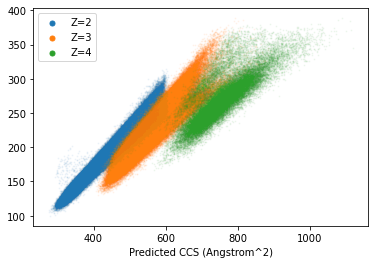

In [9]:
for c in range(2,5):
    plt.scatter(ccs_df.loc[ccs_df["Charge"]==c,"CCS"],ccs_df.loc[ccs_df["Charge"]==c,"predicted_CCS_vol_based"],alpha=0.05,s=1, label="Z="+str(c))

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

plt.xlabel("Observed CCS (Angstrom^2)")
plt.xlabel("Predicted CCS (Angstrom^2)")
    
plt.show()

Clear correlation, but seems we need to change the intercepts of each curve and make seperate predictions for each peptide charge state. Instead of spending more time on this, lets have a look at a more ML-based approach.

## Training a linear regression model for CCS prediction

In [46]:
from sklearn.linear_model import LinearRegression
import numpy as np
import random

In [61]:
all_idx = list(X_matrix_count.index)
random.seed(42)
random.shuffle(all_idx)

train_idx = all_idx[0:int(len(all_idx)*0.9)]
test_idx = all_idx[int(len(all_idx)*0.9):]

ccs_df_train = ccs_df.loc[train_idx,:]
ccs_df_test = ccs_df.loc[test_idx,:]

X_matrix_count_train = X_matrix_count.loc[train_idx,:]
X_matrix_count_test = X_matrix_count.loc[test_idx,:]

In [63]:
linear_model_z2 = LinearRegression()
linear_model_z2.fit(
    X=X_matrix_count_train.loc[ccs_df_train["Charge"]==2,:],
    y=ccs_df_train.loc[ccs_df_train["Charge"]==2,"CCS"]
)

linear_model_z3 = LinearRegression()
linear_model_z3.fit(
    X=X_matrix_count_train.loc[ccs_df_train["Charge"]==3,:],
    y=ccs_df_train.loc[ccs_df_train["Charge"]==3,"CCS"]
)

linear_model_z4 = LinearRegression()
linear_model_z4.fit(
    X=X_matrix_count_train.loc[ccs_df_train["Charge"]==4,:],
    y=ccs_df_train.loc[ccs_df_train["Charge"]==4,"CCS"]
)

LinearRegression()

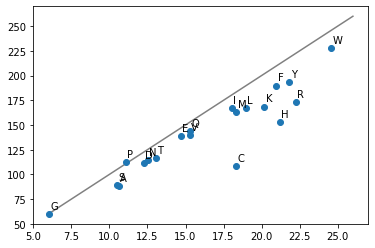

In [64]:
plt.scatter(linear_model_z2.coef_,[vol_dict[v] for v in X_matrix_count.columns])
plt.plot([6.0,26.0],[60.0,260],c="grey",zorder=0)

for v,x,y in zip(X_matrix_count.columns,linear_model_z2.coef_,[vol_dict[v] for v in X_matrix_count.columns]):
    plt.annotate(v,(x+0.1,y+5.0))
plt.show()

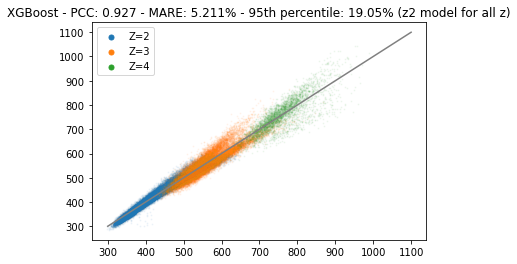

In [75]:
plt.scatter(linear_model_z2.predict(X=X_matrix_count_test.loc[ccs_df["Charge"]==2,:]),ccs_df_test.loc[ccs_df["Charge"]==2,"CCS"],alpha=0.05,s=1,label="Z=2")
plt.scatter(linear_model_z3.predict(X=X_matrix_count_test.loc[ccs_df["Charge"]==3,:]),ccs_df_test.loc[ccs_df["Charge"]==3,"CCS"],alpha=0.05,s=1,label="Z=3")
plt.scatter(linear_model_z4.predict(X=X_matrix_count_test.loc[ccs_df["Charge"]==4,:]),ccs_df_test.loc[ccs_df["Charge"]==4,"CCS"],alpha=0.05,s=1,label="Z=4")

plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

predictions = linear_model_z2.predict(X=X_matrix_count_test)
mare = round(sum((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100)/len(predictions),3)
pcc = round(pearsonr(predictions,ccs_df_test.loc[:,"CCS"])[0],3)
perc_95 = round(np.percentile((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100,95),2)

plt.title(f"Linear model - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}% (z2 model for all z)")

plt.show()

In [72]:
X_matrix_count_charge_train = X_matrix_count_train.copy()
X_matrix_count_charge_train["charge"] = ccs_df_train["Charge"]

X_matrix_count_charge_test = X_matrix_count_test.copy()
X_matrix_count_charge_test["charge"] = ccs_df_test["Charge"]

LinearRegression()

In [ ]:
linear_model = LinearRegression()
linear_model.fit(
    X=X_matrix_count_charge_train,
    y=ccs_df_train.loc[:,"CCS"]
)

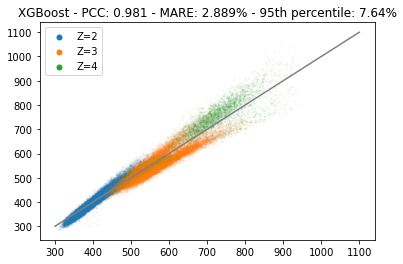

In [73]:
plt.scatter(
    linear_model.predict(X=X_matrix_count_charge_test.loc[ccs_df["Charge"]==2,:]),
    ccs_df_test.loc[ccs_df["Charge"]==2,"CCS"],
    alpha=0.05,
    s=1,
    label="Z=2"
)

plt.scatter(
    linear_model.predict(X=X_matrix_count_charge_test.loc[ccs_df["Charge"]==3,:]),
    ccs_df_test.loc[ccs_df["Charge"]==3,"CCS"],
    alpha=0.05,
    s=1,
    label="Z=3"
)

plt.scatter(
    linear_model.predict(X=X_matrix_count_charge_test.loc[ccs_df["Charge"]==4,:]),
    ccs_df_test.loc[ccs_df["Charge"]==4,"CCS"],
    alpha=0.05,
    s=1,
    label="Z=4"
)

plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)

predictions = linear_model.predict(X=X_matrix_count_charge_test)
mare = round(sum((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100)/len(predictions),3)
pcc = round(pearsonr(predictions,ccs_df_test.loc[:,"CCS"])[0],3)
perc_95 = round(np.percentile((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100,95),2)

plt.title(f"Linear model - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}%")
    
plt.show()

## Training a RF (non-linear) regression model for CCS prediction

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_matrix_count_charge_train = X_matrix_count_train.copy()
X_matrix_count_charge_train["charge"] = ccs_df_train["Charge"]

X_matrix_count_charge_test = X_matrix_count_test.copy()
X_matrix_count_charge_test["charge"] = ccs_df_test["Charge"]

In [37]:
rf_model = RandomForestRegressor(max_depth=20,n_estimators=1000)
rf_model.fit(
    X=X_matrix_count_charge_train,
    y=ccs_df_train.loc[:,"CCS"]
)

RandomForestRegressor(max_depth=20, n_estimators=1000)

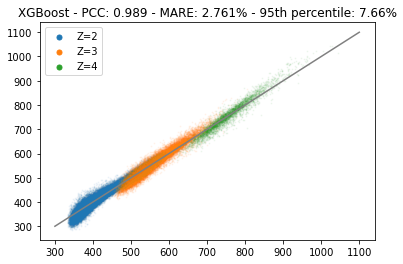

In [77]:
plt.scatter(
    rf_model.predict(X=X_matrix_count_charge_test.loc[ccs_df_test["Charge"]==2,:]),
    ccs_df_test.loc[ccs_df_test["Charge"]==2,"CCS"],
    alpha=0.05,
    s=1,
    label="Z=2"
)

plt.scatter(
    rf_model.predict(X=X_matrix_count_charge_test.loc[ccs_df_test["Charge"]==3,:]),
    ccs_df_test.loc[ccs_df_test["Charge"]==3,"CCS"],
    alpha=0.05,
    s=1,
    label="Z=3"
)

plt.scatter(
    rf_model.predict(X=X_matrix_count_charge_test.loc[ccs_df_test["Charge"]==4,:]),
    ccs_df_test.loc[ccs_df_test["Charge"]==4,"CCS"],
    alpha=0.05,
    s=1,
    label="Z=4"
)

plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)
    
predictions = rf_model.predict(X=X_matrix_count_charge_test)
mare = round(sum((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100)/len(predictions),3)
pcc = round(pearsonr(predictions,ccs_df_test.loc[:,"CCS"])[0],3)
perc_95 = round(np.percentile((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100,95),2)

plt.title(f"RF - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}%")

plt.show()

## Training a XGBoost (non-linear) regression model for CCS prediction

In [30]:
from xgboost import XGBRegressor

In [78]:
X_matrix_count_charge_train = X_matrix_count_train.copy()
X_matrix_count_charge_train["charge"] = ccs_df_train["Charge"]

X_matrix_count_charge_test = X_matrix_count_test.copy()
X_matrix_count_charge_test["charge"] = ccs_df_test["Charge"]

In [83]:
xgb_model = XGBRegressor(max_depth=12,n_estimators=1000)
xgb_model.fit(
    X=X_matrix_count_charge_train,
    y=ccs_df_train.loc[:,"CCS"]
)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

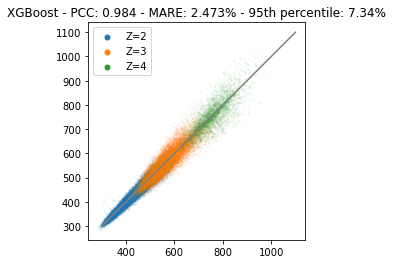

In [84]:
plt.scatter(
    ccs_df_test.loc[ccs_df_test["Charge"]==2,"CCS"],
    xgb_model.predict(X=X_matrix_count_charge_test.loc[ccs_df_test["Charge"]==2,:]),
    alpha=0.05,
    s=1,
    label="Z=2")

plt.scatter(
    xgb_model.predict(X=X_matrix_count_charge_test.loc[ccs_df_test["Charge"]==3,:]),
    ccs_df_test.loc[ccs_df_test["Charge"]==3,"CCS"],
    alpha=0.05,
    s=1,
    label="Z=3"
)

plt.scatter(
    xgb_model.predict(X=X_matrix_count_charge_test.loc[ccs_df_test["Charge"]==4,:]),
    ccs_df_test.loc[ccs_df_test["Charge"]==4,"CCS"],
    alpha=0.05,
    s=1,
    label="Z=4"
)

plt.plot([300,1100],[300,1100],c="grey")

legend = plt.legend()

for lh in legend.legendHandles:
    lh.set_sizes([25])
    lh.set_alpha(1)
    
predictions = xgb_model.predict(X=X_matrix_count_charge_test)
mare = round(sum((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100)/len(predictions),3)
pcc = round(pearsonr(predictions,ccs_df_test.loc[:,"CCS"])[0],3)
perc_95 = round(np.percentile((abs(predictions-ccs_df_test.loc[:,"CCS"])/ccs_df_test.loc[:,"CCS"])*100,95),2)

# TODO: axis labels

plt.title(f"XGBoost - PCC: {pcc} - MARE: {mare}% - 95th percentile: {perc_95}%")

ax = plt.gca()
ax.set_aspect('equal')

plt.xlabel("Observed CCS (^2)")
plt.ylabel("Predicted CCS (^2)")

plt.show()